#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала и предоставила исторические данные о заказах такси в аэропортах. 

Цели и задачи проекта:
1. Привлечение большего количества водителей в период пиковой нагрузки,
2. Прогнозирование количества заказов такси на следующий час. 
3. Построение модели такого предсказания.
4. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Описание данных:

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import os.path
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV #cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 29)
file_name = 'taxi.csv'
local_path = os.path.join('G:', os.sep, 'Мой диск', 'Data Science', 'Проекты', 'Data Science(Проекты и шпаргалки)',
                          'Проекты', '12 Такси', 'data')
web_dir_path = os.path.join(os.sep, 'datasets' + os.sep)
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
try:
    data_full  = pd.read_csv(web_dir_path + file_name, index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data_full = pd.read_csv(local_path + file_name, index_col=[0], parse_dates=[0])
else:
    print(f'Общая информация о данных датасета ', file_name, ':', sep='')
    data_full.info()
    print(f'\nОбзор данных датасета:', sep='')
    display(data_full)
    print(f'Минимальные значения в данных датасета ', file_name, ':', sep='')
    print(data_full.min(), '\n')
    print(f'Максимальные значения в данных датасета ', file_name, ':', sep='')
    print(data_full.max(), '\n')
    print(f'Количество дубликатов в данных датасета ', file_name, ':', sep='')
    print(data_full.duplicated().sum(), '\n')
    print(f'Колонки с пропущенными значениями в данных датасета ', file_name, ':\n', sep='')
    print(data_full.isna().sum(), '\n')
    print(f'Параметры распределения данных в колонках датасета ', file_name, ':\n', sep='')
    print(data_full.describe(), '\n')

Общая информация о данных датасета taxi.csv:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Обзор данных датасета:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Минимальные значения в данных датасета taxi.csv:
num_orders    0
dtype: int64 

Максимальные значения в данных датасета taxi.csv:
num_orders    119
dtype: int64 

Количество дубликатов в данных датасета taxi.csv:
26415 

Колонки с пропущенными значениями в данных датасета taxi.csv:

num_orders    0
dtype: int64 

Параметры распределения данных в колонках датасета taxi.csv:

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000 



In [3]:
def fix_monotonic(data):
    if not data.index.is_monotonic:
        print('Данные даты либо потворяются, либо перемешаны, удалим дуликаты в дата-индексе и применим сортировку, повторим проверку')
        data = data.loc[~data_full.index.duplicated(keep='first')]
        data = data.sort_index()
        print('................')
        if data_full.index.is_monotonic:
            print('Теперь данные монотонны по дата-индексу - последовательны!')
            return data
        else:
            print('Проблема не устранена, нужно разбираться с данными далее...')
    else:
        print('Данные монотонны по дата-индексу - последовательны!')
        return data
data_full = fix_monotonic(data_full)

Данные монотонны по дата-индексу - последовательны!


## Анализ

Посмотрим на график данных заказа такси почасовой, понедельный и помесячный.

In [4]:
#data_full = data_full.sort_index()

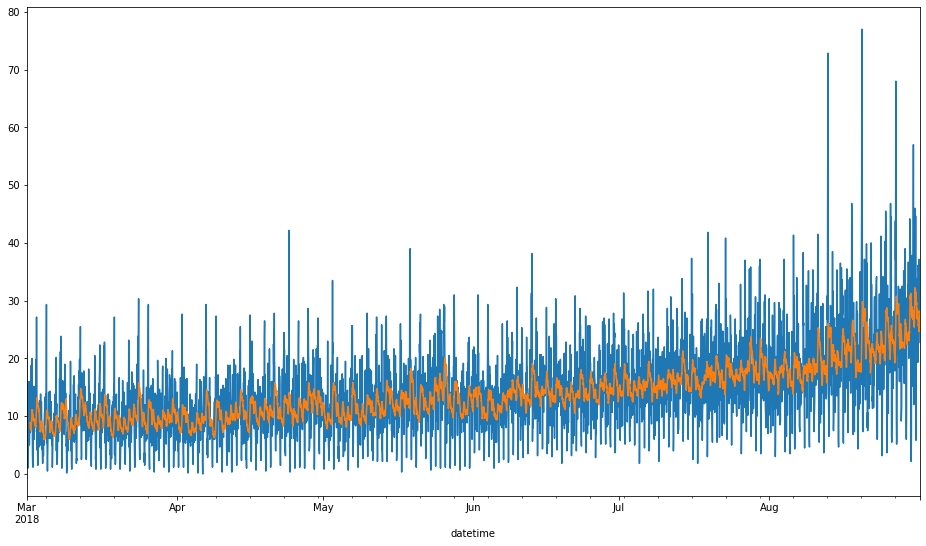

In [5]:
data_full['num_orders'].resample('H').mean().plot(x=data_full.index, y=data_full['num_orders'], figsize=(16,9));
data_full['num_orders'].rolling(100).mean().plot(x=data_full.index, y=data_full['num_orders'], figsize=(16,9));

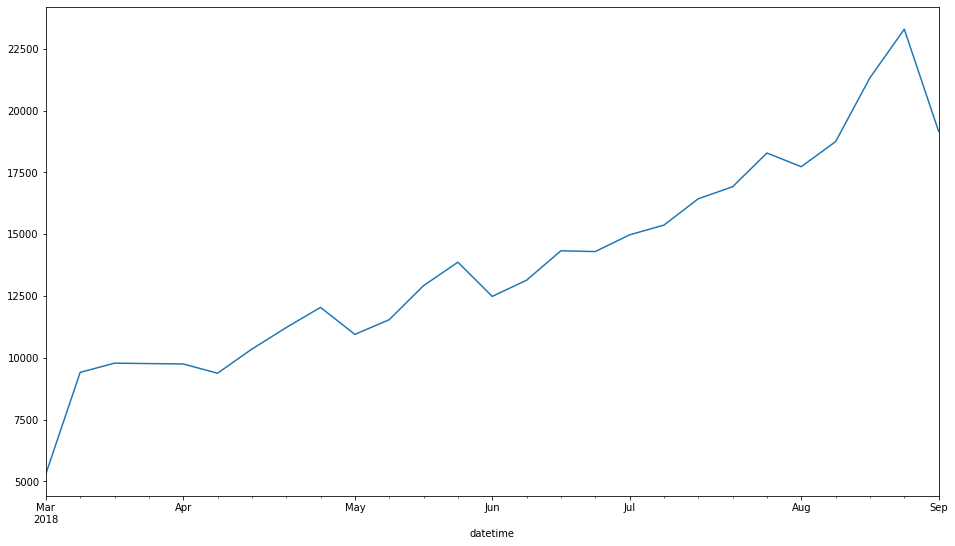

In [6]:
data_full['num_orders'].resample('W').sum().plot(x=data_full.index, y=data_full['num_orders'], figsize=(16,9));

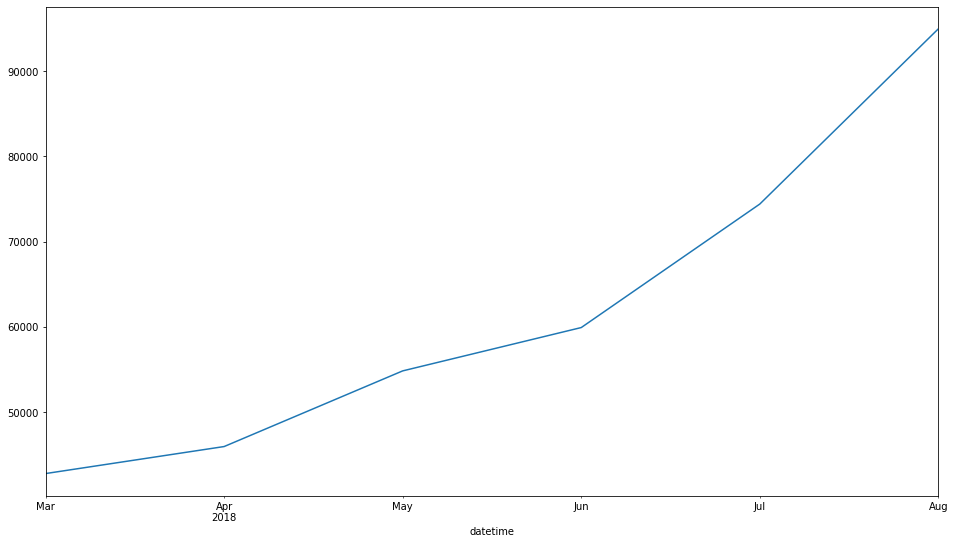

In [7]:
data_full['num_orders'].resample('M').sum().plot(x=data_full.index, y=data_full['num_orders'], figsize=(16,9));

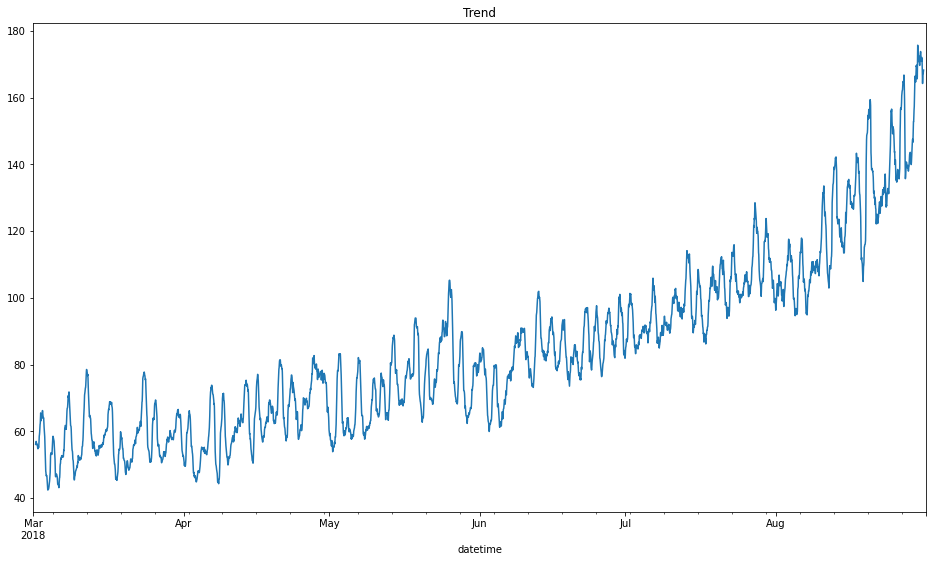

In [8]:
seasonal_decompose(data_full['num_orders'].resample('H').sum()).trend.plot(title='Trend', figsize=(16,9));

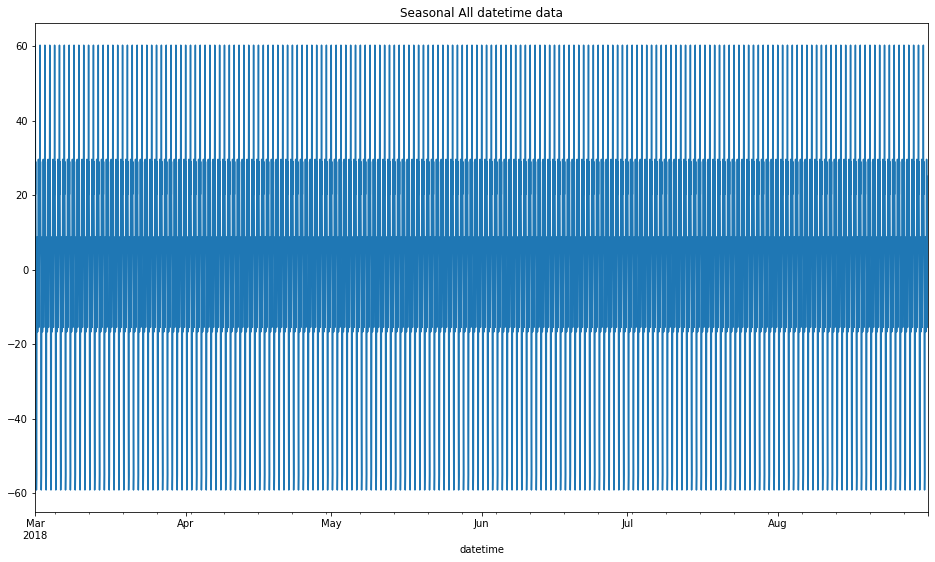

In [9]:
seasonal_decompose(data_full['num_orders'].resample('H').sum()).seasonal.plot(title='Seasonal All datetime data', figsize=(16,9));

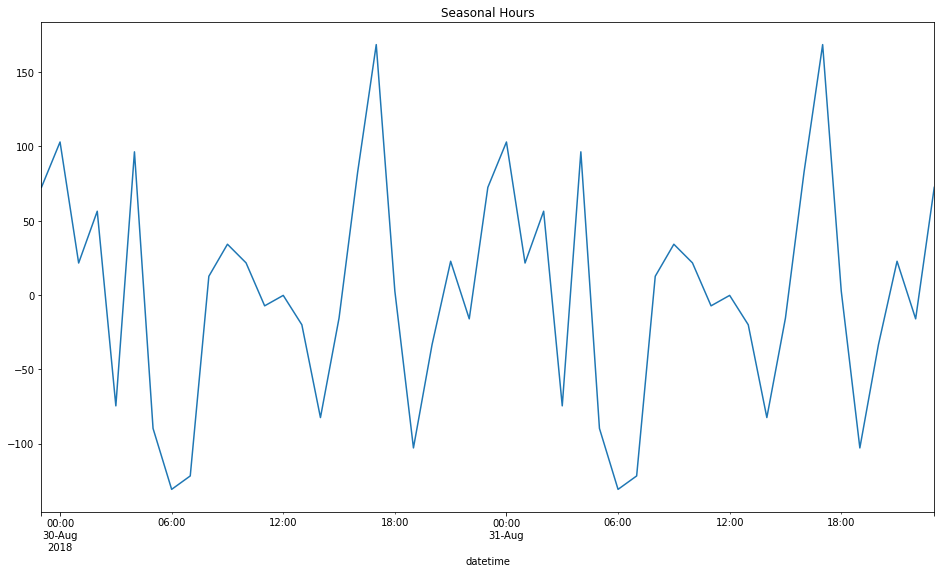

In [10]:
seasonal_decompose(data_full['num_orders']['2018-08-29 23:50:00':'2018-08-31 23:50:00'].resample('H').sum()).seasonal.plot(title='Seasonal Hours', figsize=(16,9));

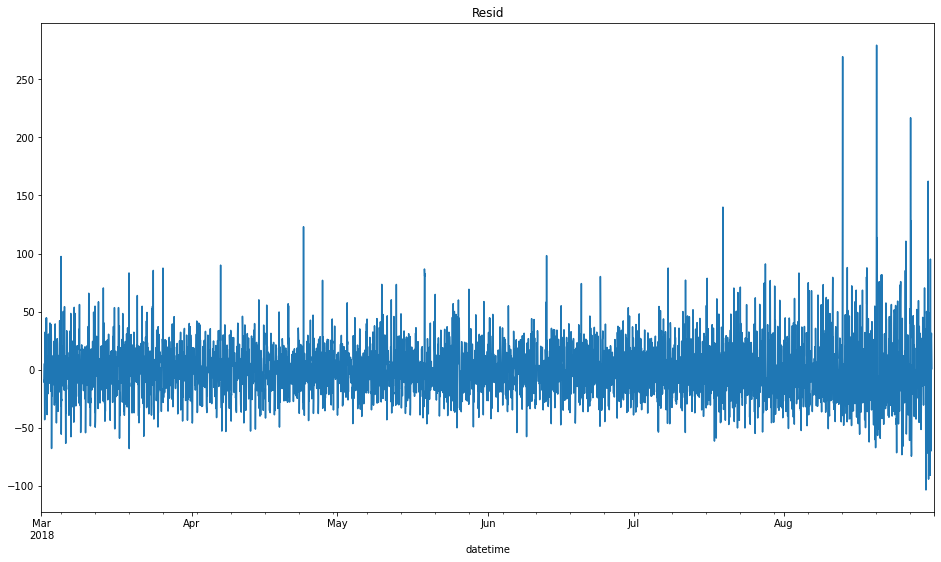

In [11]:
seasonal_decompose(data_full['num_orders'].resample('H').sum()).resid.plot(title='Resid', figsize=(16,9));

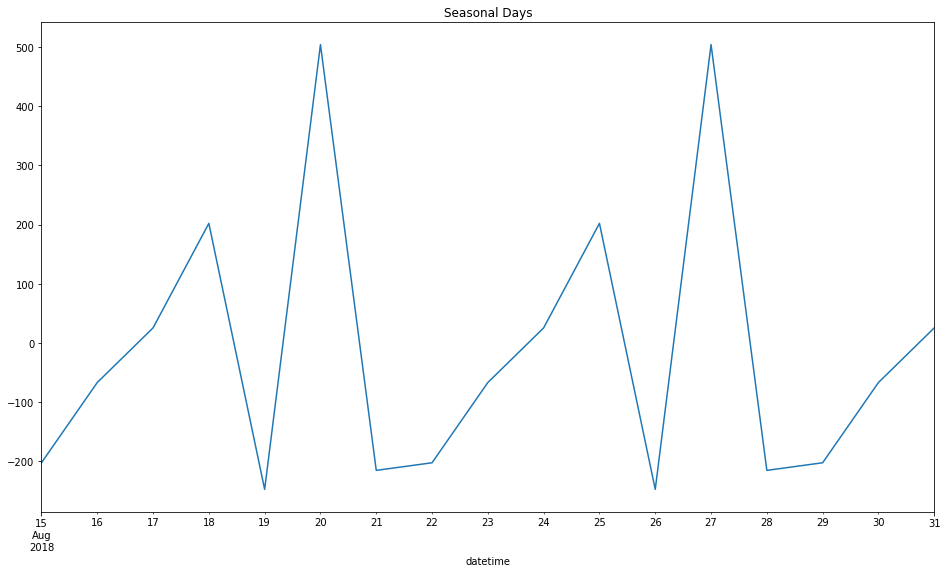

In [12]:
seasonal_decompose(data_full['num_orders']['2018-08-15 23:50:00':'2018-08-31 23:50:00'].resample('D').sum()).seasonal.plot(title='Seasonal Days', figsize=(16,9));

**Вывод**   
Сделали ресемплинг (группировку) по значениям даты с интервалом в 1 час в соответствии с условиями задания. Построили график значений, суммированных по часовым сэмплам, проиллюстрировали скользящие средние. Применили функцию decompose для формирования данных тренда, сезонности и остатков. Построили графики, на которых по данным датасета увидели восходящий тренд за период датасета, который позволяет заключить о росте популярности сервиса такси с марта по август 2018 года. В поисках сезонности проскалили отображаемый интервал до значений суток и увидели сезонность на 24-часовом интервале по графику значений, суммированных по часовым сымплам - сезонность (повторяемость) значений очевидна.

## Обучение

In [13]:
data_hr = data_full.resample('1H').sum().copy()
display(data_hr)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['year'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()

make_features(data_hr, 15, 15)
display(data_hr)

,num_orders,dayofweek,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,156.133333
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,147.333333
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,152.400000


**RandomForestRegressor**

Ограничим перемешивание при подборе параметров и при расчёте метрики кросс-валидацией

In [15]:
#k = KFold(n_splits=5, shuffle=False, random_state=None)

In [16]:
param_dist_forest = {"max_depth": [3, None],
                   "max_features": sp_randint(1, 11).rvs(2),
                   "min_samples_split": sp_randint(2, 11).rvs(2)}

In [17]:
n_splits=8
tscv = TimeSeriesSplit(n_splits=n_splits)

In [18]:
grid_rfr = GridSearchCV(RandomForestRegressor(), param_dist_forest, scoring='neg_mean_squared_error', cv=tscv)

Доля удалённых из датасета строк:
0.34 %

Количество удалённых строк из датасета:
15


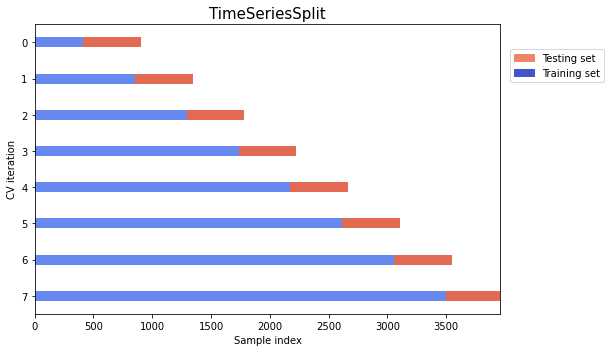

In [19]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

try:
    if not data_hr1.empty:
        pass
except NameError:
    data_hr1 = data_hr.copy()

print(f'Доля удалённых из датасета строк:')
prt = len(data_hr1.dropna())/len(data_hr1)
print(round((1 - prt) * 100, 2), '%\n')
print(f'Количество удалённых строк из датасета:')
print(len(data_hr1) - len(data_hr1.dropna()))

data_hr = data_hr.dropna()

target = data_hr['num_orders']
features = data_hr.drop(['num_orders'], axis=1)

features_train = features[:int(features.shape[0]*0.9)]
features_test = features[int(features.shape[0]*0.9):]
target_train = target[:int(target.shape[0]*0.9)]
target_test = target[int(target.shape[0]*0.9):]
features_train = features_train.dropna()
target_train = target_train.dropna()

rmse_score_rfr = []

fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr_index, tst_index) in enumerate(tscv.split(features_train, target_train)):    
    features_tr, features_tst = features_train.iloc[tr_index], features_train.iloc[tst_index]
    target_tr, target_tst = target_train.iloc[tr_index], target_train.iloc[tst_index]
    
    grid_rfr.fit(features_tr, target_tr)
    predicted = grid_rfr.predict(features_tst)
    rmse = mean_squared_error(target_tst,predicted,squared=False)
    rmse_score_rfr.append(rmse)
    
    indices = np.array([np.nan] * len(features_train))
    indices[tst_index] = 1
    indices[tr_index] = 0
    
    ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=10,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
    )
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits)  + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, 0],
        xlim=[0, len(indices)],
    )
ax.set_title("{}".format(type(tscv).__name__), fontsize=15)
ax.legend(
[Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
["Testing set", "Training set"],
loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

In [20]:
rmse_rfr = abs(np.mean(rmse_score_rfr))
print(f'Среднее значение RMSE для RandomForestRegressor с skilearn-кросс-валидацией: {rmse_rfr}')

Среднее значение RMSE для RandomForestRegressor с skilearn-кросс-валидацией: 24.53734259513839


**CatBoostRegressor**

In [36]:
param_dist_cbr = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }
cbr = CatBoostRegressor(loss_function="RMSE", verbose=10) #iterations=20, depth=10,
grid_cbr = GridSearchCV(cbr, param_dist_cbr, scoring='neg_mean_squared_error', cv=tscv)

0:	learn: 31.0259483	total: 46.9ms	remaining: 1.36s
10:	learn: 30.3076787	total: 54.3ms	remaining: 93.8ms
20:	learn: 29.5667634	total: 61.7ms	remaining: 26.4ms
29:	learn: 28.8718433	total: 68.5ms	remaining: 0us
0:	learn: 30.1395481	total: 1.71ms	remaining: 49.6ms
10:	learn: 29.2342245	total: 10.9ms	remaining: 18.9ms
20:	learn: 28.3951283	total: 20.4ms	remaining: 8.73ms
29:	learn: 27.6334378	total: 28.6ms	remaining: 0us
0:	learn: 29.0298444	total: 1.75ms	remaining: 50.7ms
10:	learn: 28.1068159	total: 13.2ms	remaining: 22.8ms
20:	learn: 27.3598715	total: 24.1ms	remaining: 10.3ms
29:	learn: 26.6274603	total: 34.4ms	remaining: 0us
0:	learn: 29.1348945	total: 1.9ms	remaining: 55.2ms
10:	learn: 28.2043746	total: 15.1ms	remaining: 26.2ms
20:	learn: 27.3740238	total: 29.1ms	remaining: 12.5ms
29:	learn: 26.6437525	total: 40.5ms	remaining: 0us
0:	learn: 29.0693564	total: 1.9ms	remaining: 55.1ms
10:	learn: 28.2180160	total: 15.7ms	remaining: 27.1ms
20:	learn: 27.3331725	total: 29.2ms	remaining: 1

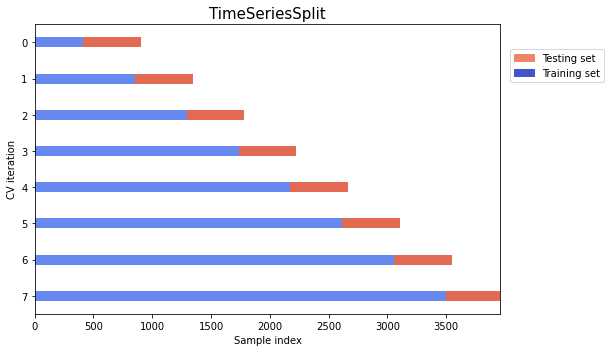

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr_index, tst_index) in enumerate(tscv.split(features_train, target_train)):    
    features_tr, features_tst = features_train.iloc[tr_index], features_train.iloc[tst_index]
    target_tr, target_tst = target_train.iloc[tr_index], target_train.iloc[tst_index]
    
    grid_cbr.fit(features_tr, target_tr)
    predicted = grid_cbr.predict(features_tst)
    rmse = mean_squared_error(target_tst,predicted,squared=False)
    rmse_score_cbr.append(rmse)
    
    indices = np.array([np.nan] * len(features_train))
    indices[tst_index] = 1
    indices[tr_index] = 0
    
    ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=10,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits)  + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, 0],
        xlim=[0, len(indices)],
    )
ax.set_title("{}".format(type(tscv).__name__), fontsize=15)
ax.legend(
[Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
["Testing set", "Training set"],
loc=(1.02, 0.8),
)

plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

In [24]:
rmse_cbr = abs(np.mean(rmse_score_cbr))
print(f'Среднее значение RMSE для CatBoostRegressor с skilearn-кросс-валидацией: {rmse_cbr}')

Среднее значение RMSE для CatBoostRegressor с skilearn-кросс-валидацией: 24.585256506305363


## Тестирование

In [31]:
target = data_hr['num_orders']
features = data_hr.drop('num_orders', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.12)

In [39]:
grid_rfr = GridSearchCV(RandomForestRegressor(), param_dist_forest, scoring='neg_mean_squared_error', cv=tscv)
grid_rfr.fit(features_train, target_train)
predicted = grid_rfr.predict(features_test)

In [40]:
display(mean_squared_error(target_test,predicted,squared=False))

47.97167126985926

**Вывод**   
Провели анализ временных данных заказов такси, сделали декомпозицию, проиллюстрировали графиками тренд, сезонность и остатки. Провели подбор параметров моделей RandomForestRegressor и CatBoostRegressor. С помощью кросс-валидации выполнии расчёт среднего значения метрики RMSE и отобрали для теста лучшую модель CatBoostRegressor, которой выполнили предсказания на тестовой выборке и рассчитали метрику RMSE. Полученные значения укладываются в параметры задания.